In [1]:
import numpy as np
from itertools import compress
import random
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10, 10)
from mpl_toolkits.mplot3d import Axes3D 
import tikzplotlib
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
float_formatter = "{:.3e}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
plt.rcParams.update({'font.size': 22})

In [2]:
!pip install matplotlib2tikz

In [3]:
def not_all_fixed(x):
    for i in x:
        if i not in [-1,1]:
            return True
    return False

def choose_pivot(x,mode='random'):
    if mode=='max':
        for i in range(len(x),0,-1):
            print(i)
            print(x)
            if not x[i] in [-1,1]:
                return i
        return -1
    if mode=='random':
        alive=list(compress(range(len(x)), np.abs(x)!=1))
        try:
            return random.choice(alive)
        except IndexError:
            #print('Every element is fixed')
            return -1
    
def next_direction(p,v,x):
    u=np.zeros(len(v))
    u[p]=1
    B=np.transpose(np.vstack(tuple([e for e in v])))
    alive_and_not_pivot=[not e in [-1,1]  for e in x]
    alive_and_not_pivot[p]=False
    alive_and_not_pivot=np.asarray(alive_and_not_pivot)
    B_t=B[:,alive_and_not_pivot]
    #print(f'B_t: {B_t}')
    #print(f'B_t^T*B_t: {np.matmul(np.transpose(B_t),B_t)}')
    #print(f'det: {np.linalg.det(np.matmul(np.transpose(B_t),B_t))}')
    u1=-np.matmul(np.matmul(inv(np.matmul(np.transpose(B_t),B_t)),np.transpose(B_t)),v[p])
    #print(f'u:{u}')
    #print(f'u1:{u1}')
    u[alive_and_not_pivot]=u1
    #print(f'u:{u}')
    return u

def next_factor(x,u):
    non_zero=np.abs(u)>1e-15
    x_=x[non_zero]
    deltas=np.concatenate(((np.ones(len(x_))-x_)/u[non_zero],(-np.ones(len(x_))-x_)/u[non_zero]),axis=0)
    #print(deltas)
    d_p=min(deltas[deltas>0])
    d_m=max(deltas[deltas<0])
    r=random.random()
    if r>d_p/(d_p-d_m):
        return d_p,d_m
    return d_m,d_p
    

def gram_schmidt_walk(v,x,plot=False):
    p=choose_pivot(x)
    i=1
    while not_all_fixed(x) and p!=-1:
        u=next_direction(p,v,x)
        d1,d2=next_factor(x,u)
        if plot:
            plot_situation_v2(v,p,x,u,[d1,d2],i)
        x+=d1*u
        #print(f'x:{x}')
        if x[p] in [-1,1]:
            p=choose_pivot(x)
        i+=1
    return x

def sample_from_sphere(n):
    thetas=np.random.uniform(0,2*np.pi,n)
    return [np.array([np.sin(t),np.cos(t)]) for t in thetas]

def sample_from_ball(n,d=2):
    p=[]
    for i in range(n):
        u = np.random.normal(0,1,d)  # an array of d normally distributed random variables
        norm=np.sum(u**2) **(0.5)
        r = random.random()**(1.0/d)
        p.append(r*u/norm)
    return p
    #r = np.random.uniform(0,1,n)**0.5
    #theta = np.random.uniform(0,2*np.pi,n)
    #x = r*np.cos(theta)
    #y = r*np.sin(theta)
    #return [np.array([x[i],y[i]]) for i in range(n)]

def inv(m):
    a,_ = m.shape
    i = np.eye(a, a)
    return np.linalg.lstsq(m, i)[0]

def latex_vector(x):
    return str(list(x)).replace('[','').replace(']','').replace(',','\\ \n')

def plot_situation(v,p,x,u,deltas,i):
    #plot vectors, combination where it is now, two potential updates,show x and deltas and u
    plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
    B=np.transpose(np.vstack(tuple([e for e in v])))
    plt.plot(np.matmul(B,x)[0],np.matmul(B,x)[1],'X',label='Current relaxation',markersize=15)
    x_1=x+deltas[0]*u
    x_2=x+deltas[1]*u
    xs=[x_1,x_2]
    print(f'xs: {xs}')
    print(f'sum:{[np.matmul(B,x) for x in xs]}')
    plt.plot([np.matmul(B,x)[0] for x in xs],[np.matmul(B,x)[1] for x in xs],'H',label='Potential updated relaxation')
    #plt.figtext(0.63,0.05, f"$x_t=\begin%{latex_vector(np.round(x,3))}\end%$\\ \n $u_t=\begin%{latex_vector(np.round(u,3))}\end%$\\ \n $\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$".replace('%','{pmatrix}'))
    plt.figtext(0.63,0.05, f"$\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$")
    plt.legend(bbox_to_anchor=(1.8, 1))
    tikzplotlib.save(f"gswalk{i}2d.tex")
    plt.show()
    if x.shape[0]==3:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')

        sn = 1   #limits in x,y,z
        x1, x2 = -sn, sn
        y1, y2 = -sn, sn    
        z1, z2 = -sn, sn
        ax.scatter(x[0],x[1],x[2],label='Current coloring')
        ax.scatter([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]])

        # Data for plotting plane x|y|z=0 within the domain
        tmp = np.linspace(-1, sn, 8)
        x,y = np.meshgrid(tmp,tmp)
        z = 0*x

        ax.plot_surface(z+1,x,y, alpha=0.15, color='red')    # plot the plane x=1
        ax.plot_surface(z-1,x,y, alpha=0.15, color='red')    # plot the plane x=-1
        ax.plot_surface(x,z+1,y, alpha=0.15, color='green')  # plot the plane y=1
        ax.plot_surface(x,z-1,y, alpha=0.15, color='green')  # plot the plane y=-1
        ax.plot_surface(x,y,z+1, alpha=0.15, color='blue')   # plot the plane z=1
        ax.plot_surface(x,y,z-1, alpha=0.15, color='blue')   # plot the plane z=-1
        ax.plot([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Update direction')

        # Set limits of the 3D display
        ax.set_xlim3d([-sn, sn])
        ax.set_ylim3d([-sn, sn])
        ax.set_zlim3d([-sn, sn])

        # Set labels at the 3d box/frame
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.savefig(f"gswalk{i}3d.png")
        plt.legend()
        tikzplotlib.save(f"gswalk{i}3d.tex")
        plt.show()
        
def plot_situation_v2(v,p,x,u,deltas,i):
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    fig = plt.figure(figsize=plt.figaspect(0.5))
    fig.subplots_adjust(wspace=0.1, hspace=0)
    ax1 = fig.add_subplot(1, 2, 2)
    #plot vectors, combination where it is now, two potential updates,show x and deltas and u
    ax1.plot([v[e][0] for e in range(len(v)) if np.abs(x[e])<1],[v[e][1] for e in range(len(v)) if np.abs(x[e])<1],'o',label='Colorless vector')
    ax1.plot([v[e][0] for e in range(len(v)) if np.abs(x[e])==1],[v[e][1] for e in range(len(v)) if np.abs(x[e])==1],'o',label='Colored vector')
    ax1.plot(v[p][0],v[p][1],'*',label='Pivot vector',markersize=12)
    B=np.transpose(np.vstack(tuple([e for e in v])))
    ax1.plot(np.matmul(B,x)[0],np.matmul(B,x)[1],'X',label='Current balance',markersize=15)
    x_1=x+deltas[0]*u
    x_2=x+deltas[1]*u
    xs=[x_1,x_2]
    print(f'xs: {xs}')
    print(f'sum:{[np.matmul(B,x) for x in xs]}')
    ax1.plot([np.matmul(B,x)[0] for x in xs],[np.matmul(B,x)[1] for x in xs],'<',label='Potential update')
    #plt.figtext(0.63,0.05, f"$x_t=\begin%{latex_vector(np.round(x,3))}\end%$\\ \n $u_t=\begin%{latex_vector(np.round(u,3))}\end%$\\ \n $\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$".replace('%','{pmatrix}'))
    plt.figtext(0.45,0.04, f"$\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$")
    #ax1.legend(bbox_to_anchor=(0,0),loc='lower center')

    #tikzplotlib.save(f"gswalk{i}2d.tex")
    #plt.show()
    if x.shape[0]==3:
        #fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 2, 1, projection='3d')

        sn = 1   #limits in x,y,z
        x1, x2 = -sn, sn
        y1, y2 = -sn, sn    
        z1, z2 = -sn, sn

        # Data for plotting plane x|y|z=0 within the domain
        tmp = np.linspace(-1, sn, 8)
        x_,y = np.meshgrid(tmp,tmp)
        z = 0*x_

        ax.plot_surface(z+1,x_,y, alpha=0.15, color='red')    # plot the plane x=1
        ax.plot_surface(z-1,x_,y, alpha=0.15, color='red')    # plot the plane x=-1
        ax.plot_surface(x_,z+1,y, alpha=0.15, color='green')  # plot the plane y=1
        ax.plot_surface(x_,z-1,y, alpha=0.15, color='green')  # plot the plane y=-1
        ax.plot_surface(x_,y,z+1, alpha=0.15, color='blue')   # plot the plane z=1
        ax.plot_surface(x_,y,z-1, alpha=0.15, color='blue')   # plot the plane z=-1
        ax.scatter(x[0],x[1],x[2],label='Current coloring')
        ax.scatter([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Potential update')
        ax.plot([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Update direction')

        # Set limits of the 3D display
        ax.set_xlim3d([-sn, sn])
        ax.set_ylim3d([-sn, sn])
        ax.set_zlim3d([-sn, sn])

        # Set labels at the 3d box/frame
        #ax.set_xlabel('X')
        #ax.set_ylabel('Y')
        #ax.set_zlabel('Z')
        ax.legend(bbox_to_anchor=(0.8, -0.07))
    ax1.legend(bbox_to_anchor=(1.1, -0.07),ncol=2)
    plt.savefig(f"gswalkboth{i}.pdf", bbox_inches='tight')
    tikzplotlib.save(f"gswalk{i}both.tex")
    plt.show()
    
def naive_walk(vs):
    random.shuffle(vs)
    x=[1]+[0]*(len(vs)-1)
    output=vs[0]
    for i in range(1,len(vs)):
        v=vs[i]
        if norm(output+v)<norm(output-v):
            x[i]=1
            output+=v
        else:
            x[i]=-1
            output-=v
    return x

def norm(v):
    return sum(v**2)

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[]


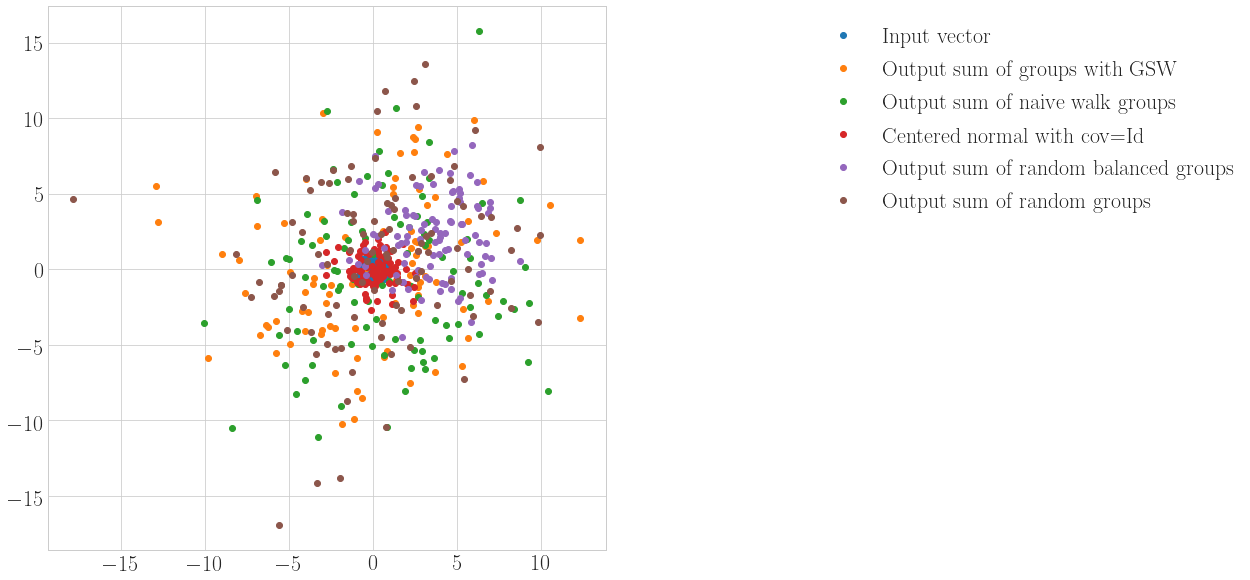

In [21]:
n=100
v=sample_from_sphere(n)
v=sample_from_ball(n)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
rand_xs=[]
balanced_xs=[]
subteam = [0] * int(n/2) + [1] * int(n/2)
naive_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n)))
    rand_xs.append(2*np.random.randint(2,size=n)-1)
    random.shuffle(subteam)
    balanced_xs.append(subteam.copy())
    naive_xs.append(naive_walk(v))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
normals=np.random.multivariate_normal(np.zeros(2), np.diag(np.ones(2)), size=n)
plt.plot([np.matmul(B,x)[0] for x in naive_xs],[np.matmul(B,x)[1] for x in naive_xs],'o',label='Output sum of naive walk groups')
plt.plot(normals[:,0],normals[:,1],'o',label='Centered normal with cov=Id')
plt.plot([np.matmul(B,x)[0] for x in balanced_xs],[np.matmul(B,x)[1] for x in balanced_xs],'o',label='Output sum of random balanced groups')
plt.plot([np.matmul(B,x)[0] for x in rand_xs],[np.matmul(B,x)[1] for x in rand_xs],'o',label='Output sum of random groups')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

v:[array([1.015e-01, -5.445e-01]), array([8.514e-02, 5.259e-01]), array([-1.143e-01, 4.897e-01])]
xs: [array([1.000e+00, 1.232e-01, 9.796e-01]), array([-1.000e+00, -1.232e-01, -9.796e-01])]
sum:[array([1.804e-16, 3.331e-16]), array([-1.804e-16, -3.331e-16])]


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


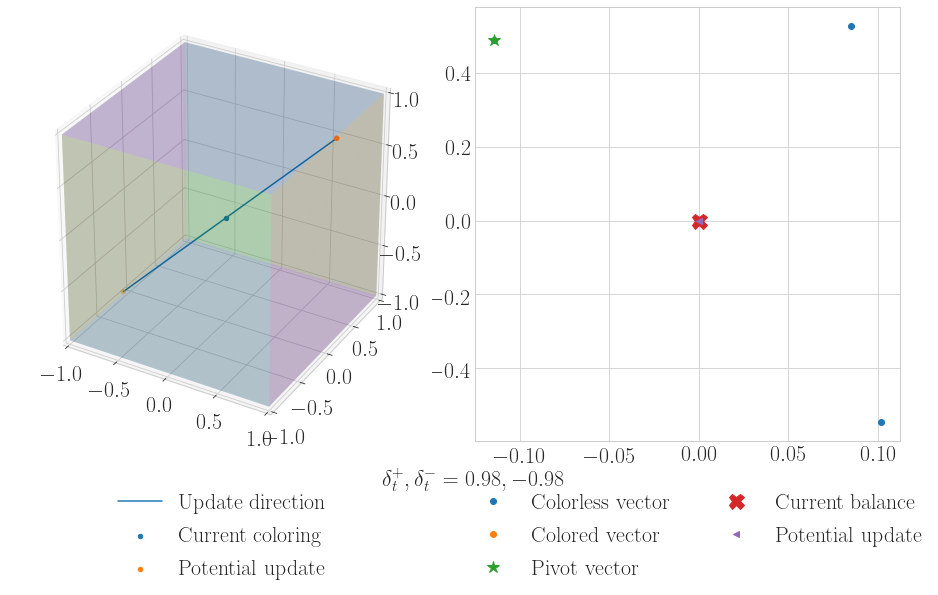

xs: [array([1.000e+00, 1.054e-01, 1.000e+00]), array([1.000e+00, 1.000e+00, -2.457e-02])]
sum:[array([-3.849e-03, 6.231e-04]), array([1.894e-01, -3.067e-02])]


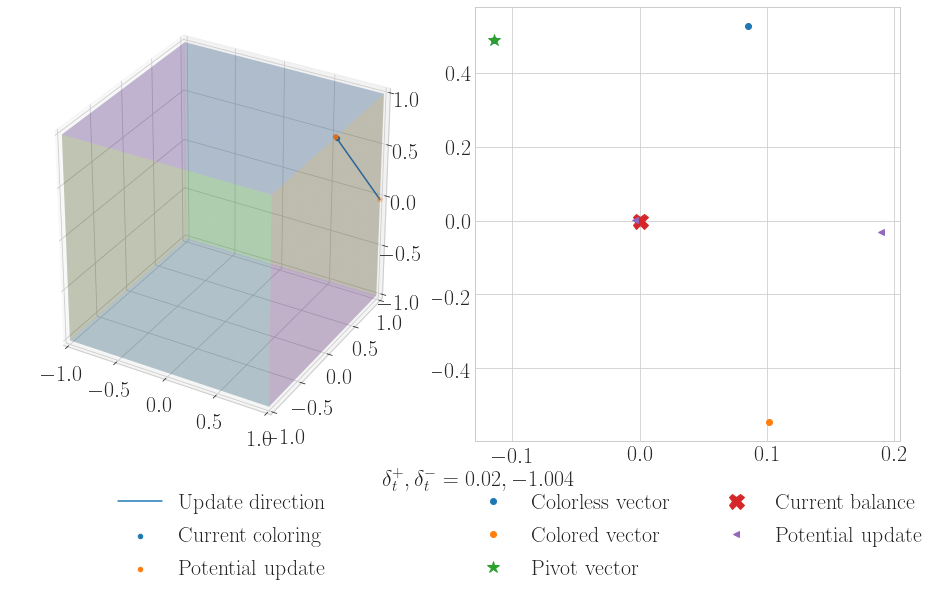

xs: [array([1.000e+00, -1.000e+00, 1.000e+00]), array([1.000e+00, 1.000e+00, 1.000e+00])]
sum:[array([-9.796e-02, -5.807e-01]), array([7.232e-02, 4.711e-01])]


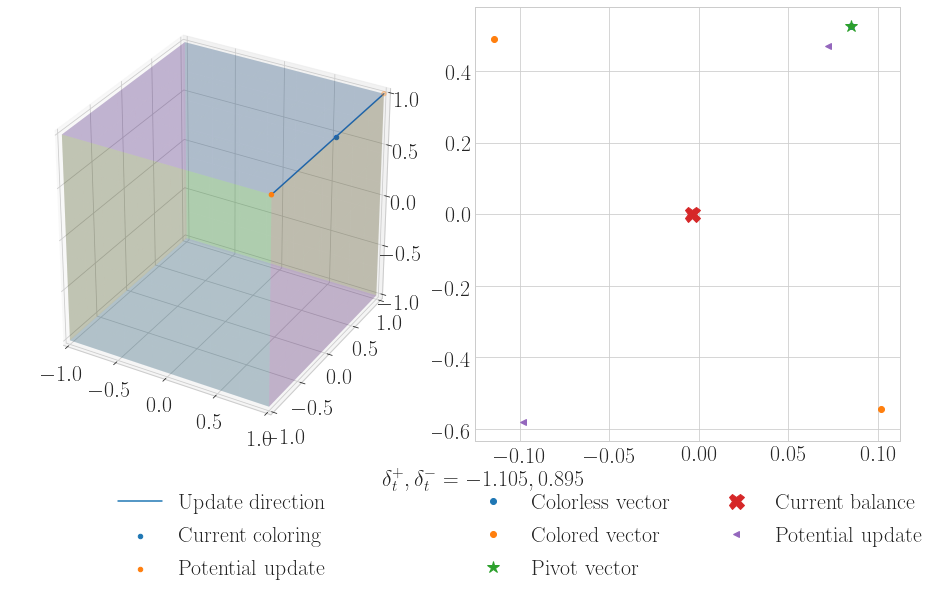

In [34]:
n=3
v=sample_from_sphere(n)
v=sample_from_ball(n)
print(f'v:{v}')
xs=[]
x=gram_schmidt_walk(v,np.zeros(n),plot=True)

[[[1.000e+00 1.000e+00]
  [1.000e+00 1.000e+00]]]


{(0, 0, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x5bef7c8>,
 (0, 0, 1): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x5ccce08>,
 (0, 1, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x5ccc908>,
 (0, 1, 1): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x8d6f088>}

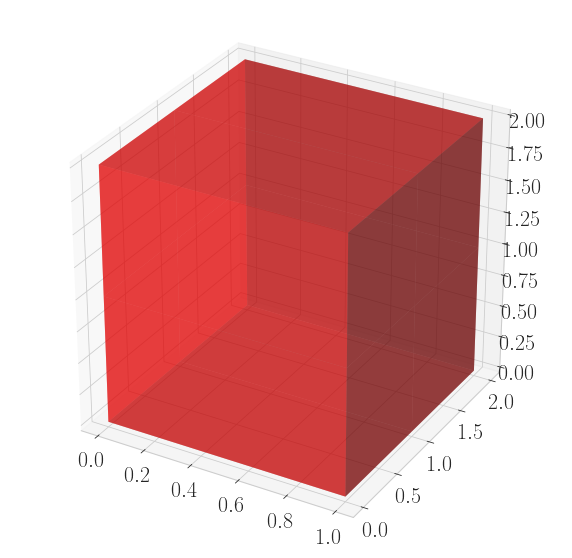

In [33]:
# Create axis
axes = [1, 2, 2]
  
# Create Data
data = np.ones(axes)
print(data)
# Controll Tranperency
alpha = 0.5
  
# Control colour
colors = np.empty(axes + [4], dtype=np.float32)
  
colors[:] = [1, 0, 0, alpha]  # red
  
# Plot figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
  
# Voxels is used to customizations of the
# sizes, positions and colors.
ax.voxels(data, facecolors=colors)

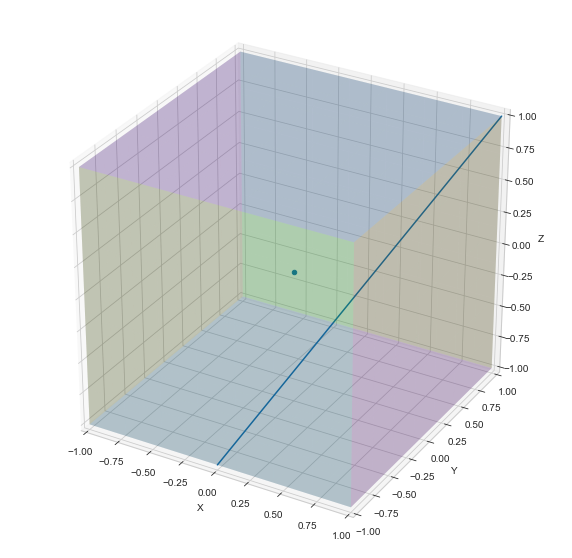

In [38]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

# Quivers for axes x,y,z from (0,0,0)
#quiver1 = ax.quiver([0],[0],[0],[2],[0],[0], colors='r')
#quiver2 = ax.quiver([0],[0],[0],[0],[2],[0], colors='g')
#quiver3 = ax.quiver([0],[0],[0],[0],[0],[2], colors='b')

# Some settings
sn = 1   #limits in x,y,z
n = 50   #number of sample points
x1, x2 = -sn, sn
y1, y2 = -sn, sn    
z1, z2 = -sn, sn

# Data for points
#xs = (x2 - x1)*np.random.rand(n) + x1
#ys = (y2 - y1)*np.random.rand(n) + y1
#zs = (z2 - z1)*np.random.rand(n) + z1

# Points with z >= 0, plotted in green
#ax.scatter(xs[zs>=0], ys[zs>=0], zs[zs>=0], color='green')
# Points with z < 0, plotted in red
#ax.scatter(xs[zs<0], ys[zs<0], zs[zs<0], color='red')
ax.scatter(0,0,0)
# Data for plotting plane x|y|z=0 within the domain
tmp = np.linspace(-1, sn, 8)
x,y = np.meshgrid(tmp,tmp)
z = 0*x

ax.plot_surface(z+1,x,y, alpha=0.15, color='red')    # plot the plane x=1
ax.plot_surface(z-1,x,y, alpha=0.15, color='red')    # plot the plane x=-1
ax.plot_surface(x,z+1,y, alpha=0.15, color='green')  # plot the plane y=1
ax.plot_surface(x,z-1,y, alpha=0.15, color='green')  # plot the plane y=-1
ax.plot_surface(x,y,z+1, alpha=0.15, color='blue')   # plot the plane z=1
ax.plot_surface(x,y,z-1, alpha=0.15, color='blue')   # plot the plane z=-1
ax.plot([0,1], [-1,1],zs=[-1,1])

# Set limits of the 3D display
ax.set_xlim3d([-sn, sn])
ax.set_ylim3d([-sn, sn])
ax.set_zlim3d([-sn, sn])

# Set labels at the 3d box/frame
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

0.7978845608028655
1.0
1.2533141373155003
1.4142135623730951
1.595769121605731
1.7320508075688772
1.8799712059732505
2.0
2.1276921621409746
2.23606797749979
2.3499640074665633
2.449489742783178
2.553230594569169
2.6457513110645907
2.741624675377657
2.8284271247461903
2.9179778223647648
3.0
3.084327759799864
3.1622776601683795
3.2421975804052945
3.3166247903554
3.3927605357798503
3.4641016151377544
3.536942814987594
3.605551275463989
3.6754905804281717
3.7416573867739413
3.8090153392174084
3.872983346207417
3.9380256218873266
4.0
4.062949695165236
4.123105625617661
4.184152223255285
4.242640687119285
4.3019467360573085
4.358898943540674


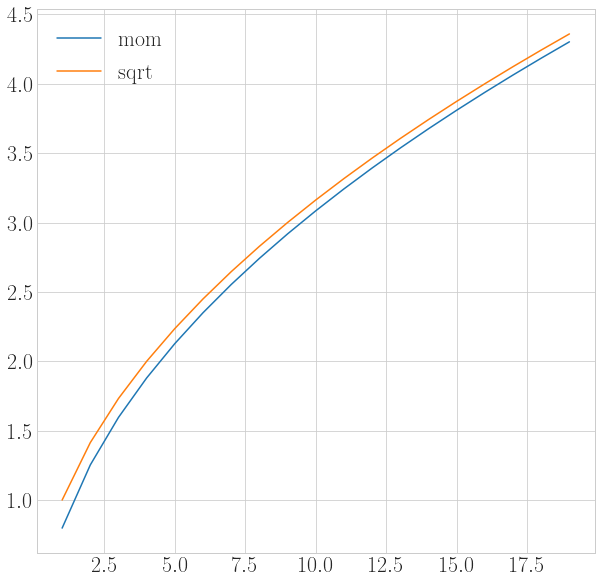

In [8]:
from scipy.special import gamma,gammainc
mom=[]
sqrt=[]
n=20
for i in range(1,n):
    mommy=2**(1/2)*gamma((i+1)/2)/gamma(i/2)
    print(mommy)
    print(np.sqrt(i))
    mom.append(mommy)
    sqrt.append(np.sqrt(i))
plt.plot(range(1,n),mom,label='mom')
plt.plot(range(1,n),sqrt,label='sqrt')
plt.legend()
plt.savefig('test.pgf')

In [42]:
#Gaussian measure of d-dimensional ball of radius r
for d in range(1,10**30,10**12):
    c=5
    r=c*(1+d)**(1/2)
    measure=gammainc(d/2,(r**2)/2)#/gamma(d/2)
    if measure<0.5:
        print(d)

KeyboardInterrupt: 

n=10
2


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


8
32
128
512


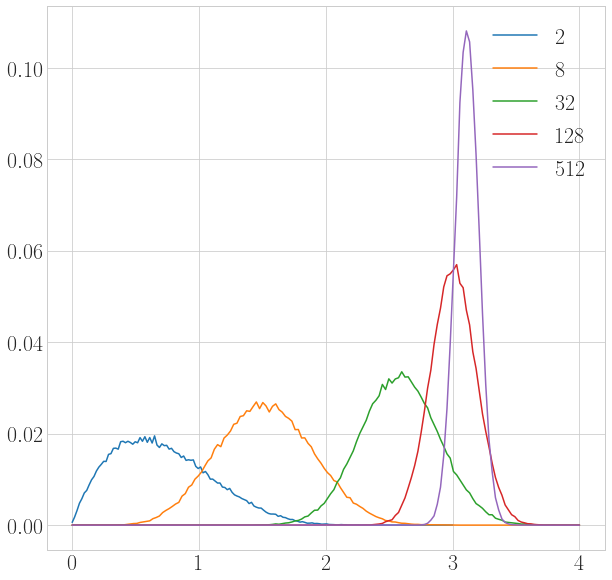

n=20
2
8
32
128
512


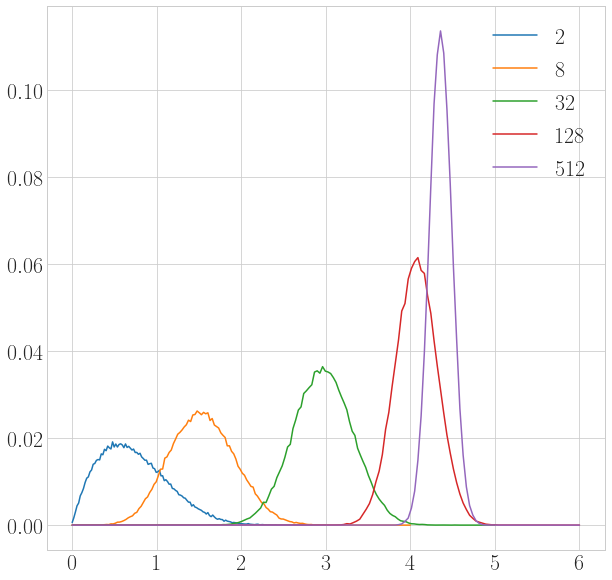

n=40
2
8
32
128
512


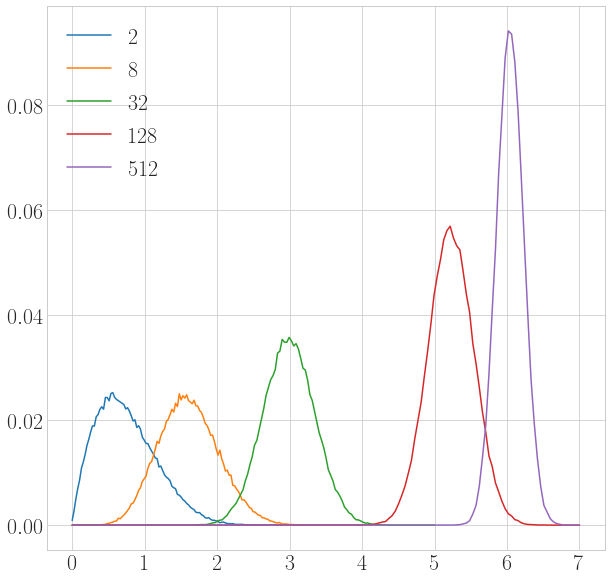

In [6]:
#maybe multiplot with different n ?
l=[2,8,32,128,512]
n_list=[10,20,40]
repeat=10**5
norms={}
for n in n_list:
    print(f'n={n}')
    norms[n]={}
    for d in l:
        print(d)
        norms[n][d]=[]
        for i in range(repeat):
            v=sample_from_ball(n,d=d)
            x=gram_schmidt_walk(v,np.zeros(n))
            B=np.transpose(np.vstack(tuple([e for e in v])))
            norms[n][d].append(np.sqrt(sum([x_**2 for x_ in np.matmul(B,x)])))
        h=int(np.ceil(max(norms[n][d])))
        split=int(np.sqrt(repeat)/2)
        r=np.linspace(0,h,split)
        num=[sum(map(lambda x:int((norm<=x) and (x<(norm+h/split))),norms[n][d]))/repeat for norm in r]
        plt.plot(r,num,label=str(d))
    plt.legend()
    plt.savefig(f'norms{n}.pdf')
    tikzplotlib.save(f"norms_n{n}.tex")
    plt.show()